## **Import Packages**

In [ ]:
%config Completer.use_jedi = False
import numpy as np
import pickle as pk
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio.v2 as imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img, plot_model
from keras.callbacks import EarlyStopping

import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Avoid OOM errors by setting memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# directory = r'/media/tshingan/Bita 4.3/_. acad/Mjrproj/lung cancer/The IQ-OTHNCCD lung cancer dataset'
directory = r'/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset'
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

### Image Size Variations

In [ ]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 801': 28,
  '512 x 512': 504,
  '512 x 623': 31,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 417, '331 x 506': 1}}

Bengin cases


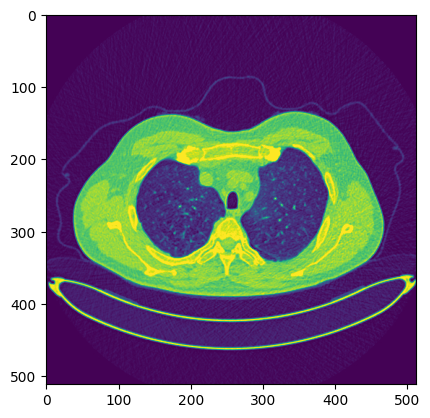

Malignant cases


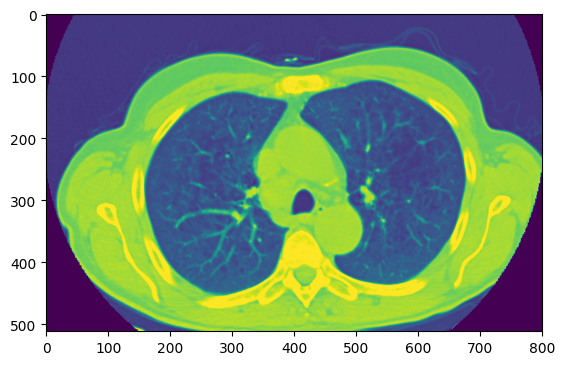

Normal cases


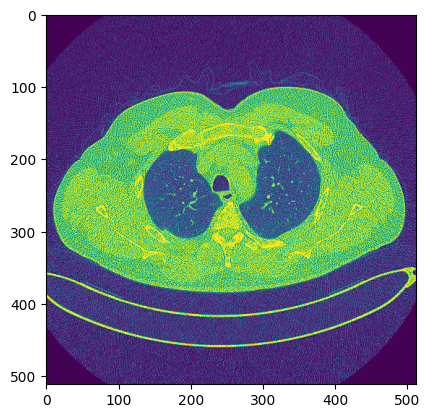

In [ ]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

### Image Preprocessing and Testing

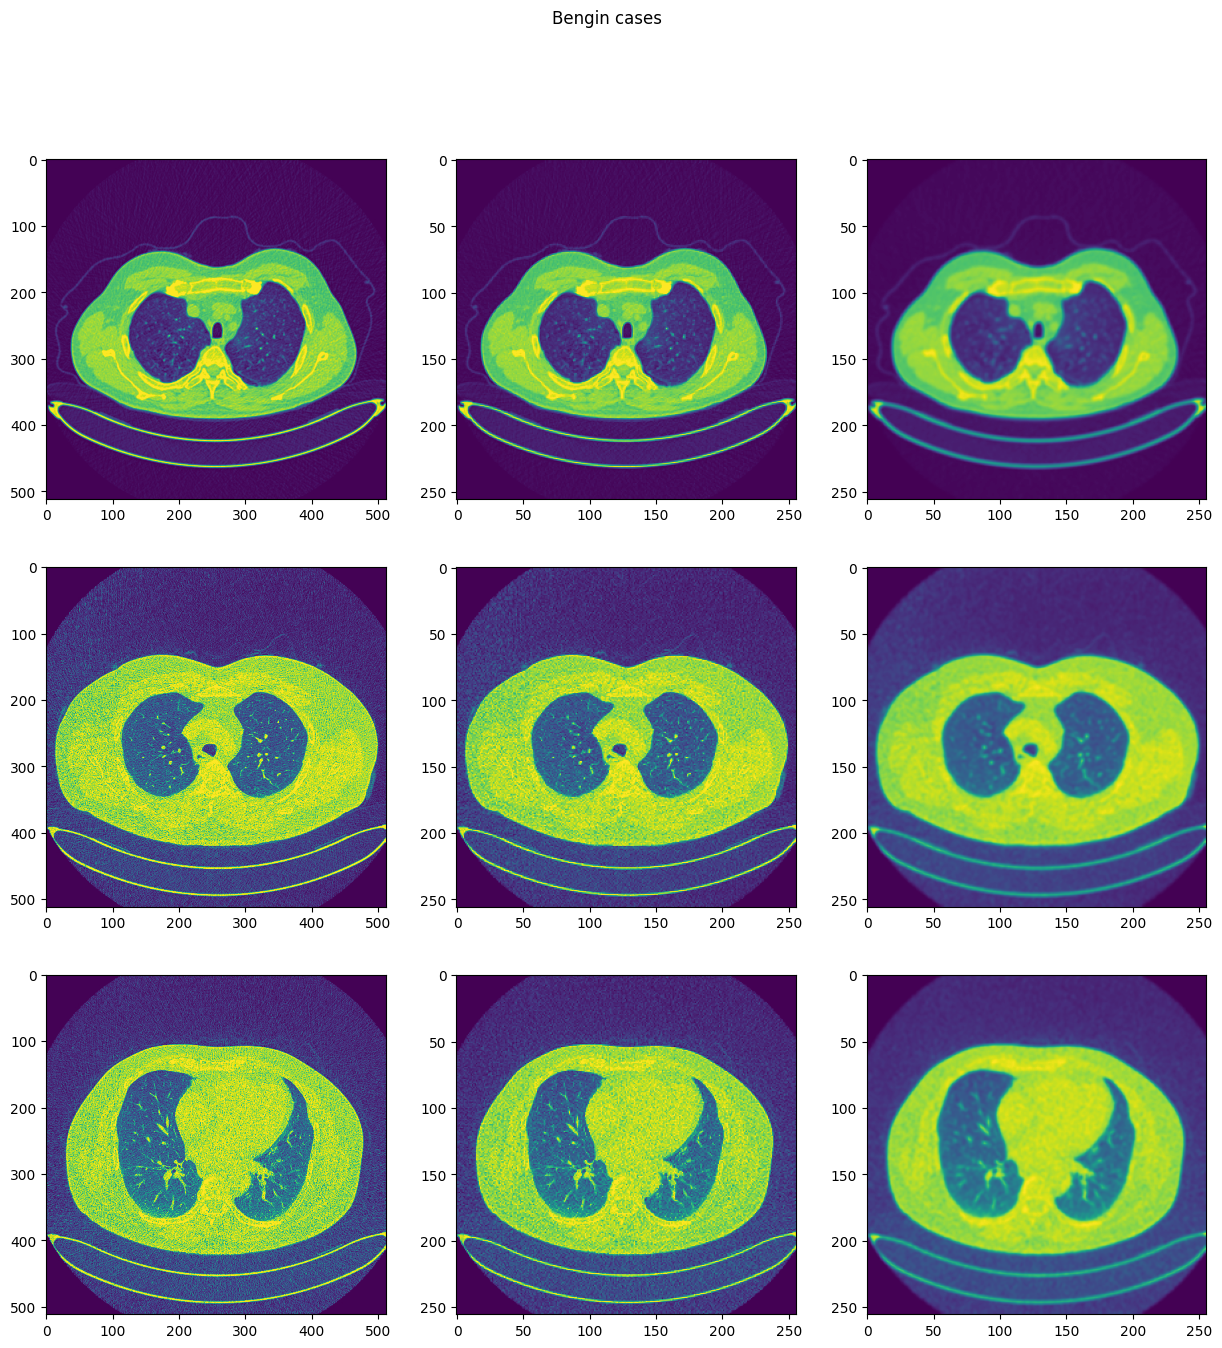

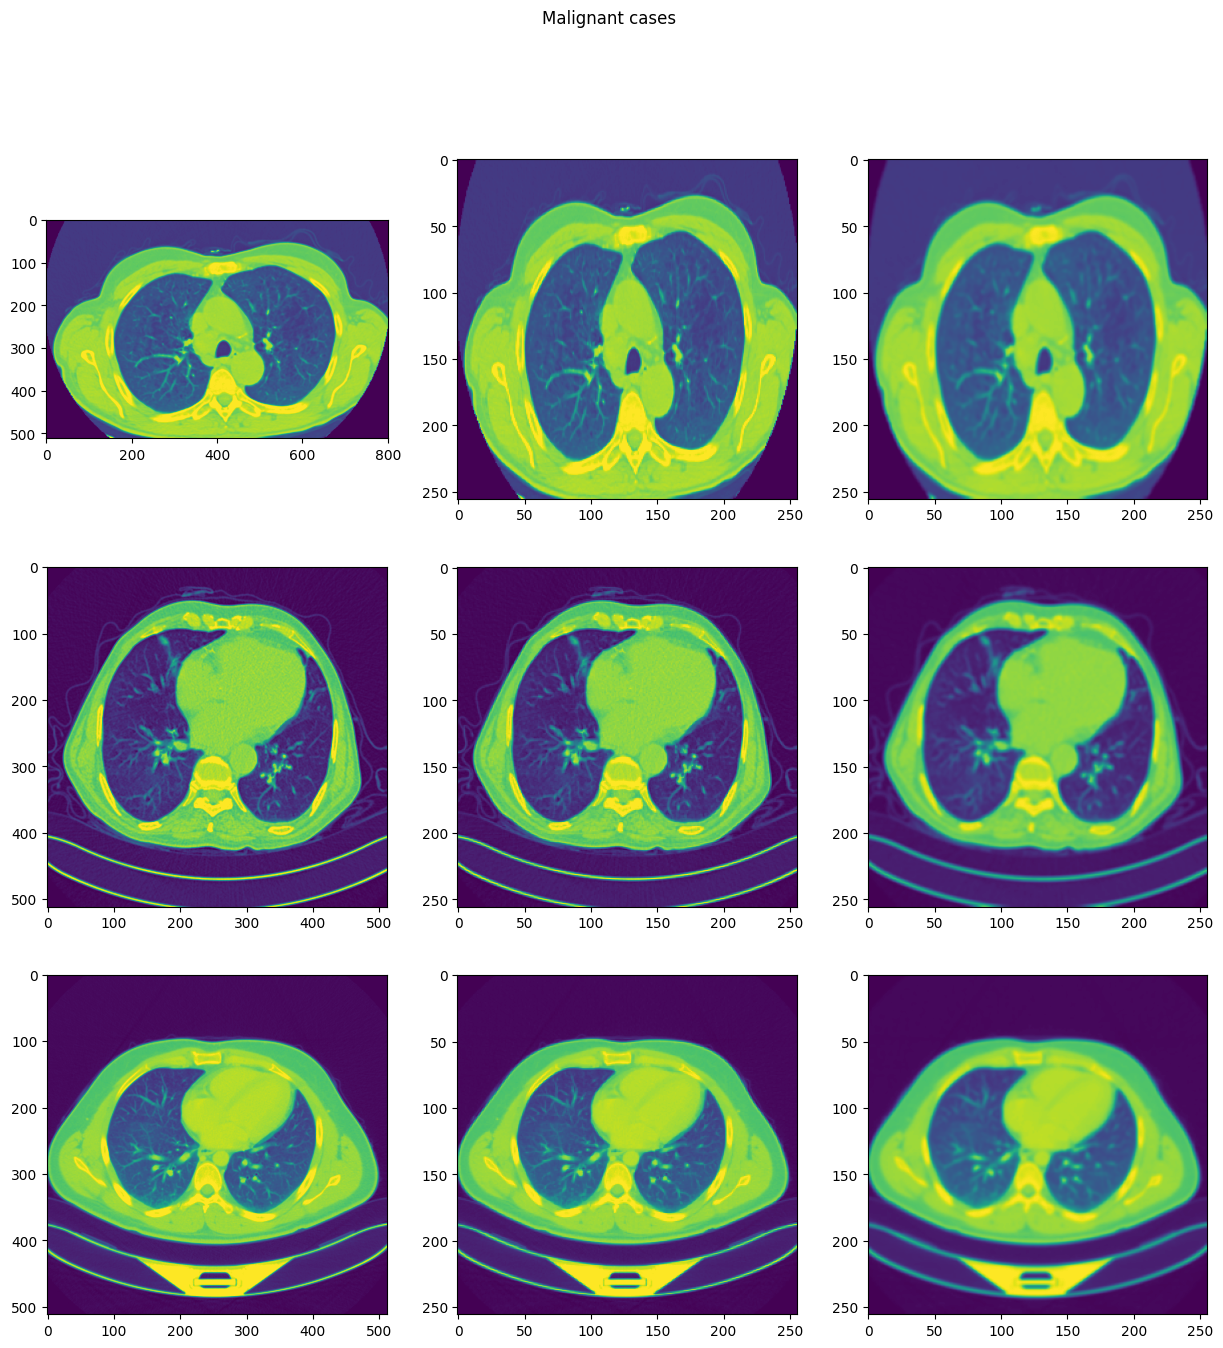

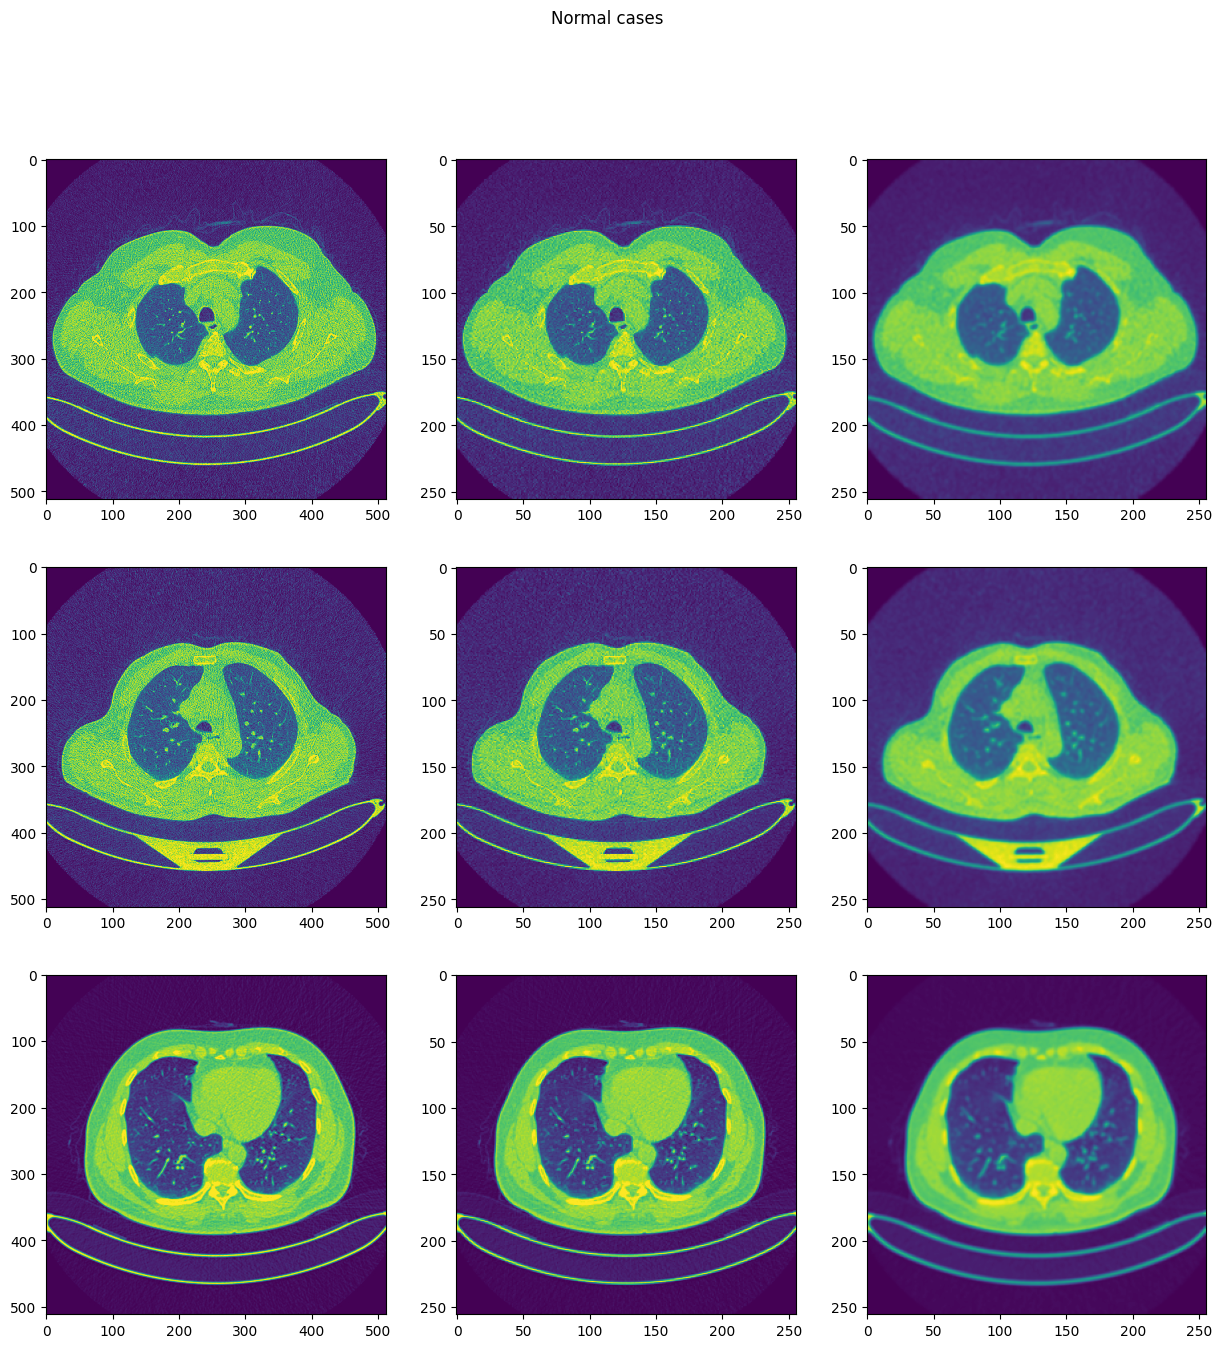

In [ ]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

## **Preparing Data**

In [ ]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1102
y counts: Counter({1: 564, 2: 418, 0: 120})


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 826 (826, 256, 256, 1)
Test length: 276 (276, 256, 256, 1)


### **Applying SMOTE to oversample the data**

In [ ]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 418, 2: 312, 0: 96}) Counter({1: 146, 2: 106, 0: 24})


In [ ]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

826 (826, 256, 256, 1)
826 (826, 65536)


In [ ]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 418, 2: 312, 0: 96})
After SMOTE: Counter({1: 418, 2: 418, 0: 418})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

826 (826, 256, 256, 1)
1254 (1254, 256, 256, 1)


In [ ]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)

## **Model Building**

In [ ]:
# Load the pre-trained ResNet50 model without the top classification layer
resnet_base = ResNet50(weights=None, include_top=False, input_shape=X_train.shape[1:])

# Freeze the pre-trained layers so they are not updated during training
for layer in resnet_base.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the ResNet50 base model
model.add(resnet_base)

# Added custom classification layers on top
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23581440  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 40359171 (153.96 MB)
Trainable params: 16777731 (64.00 MB)
Non-trainable params: 23581440 (89.96 MB)
_________________________________________________________________


In [ ]:
# simple early stopping
callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])

Epoch 1/20
104/104 [==============================] - 17s 87ms/step - loss: 0.9647 - accuracy: 0.5642 - val_loss: 0.6972 - val_accuracy: 0.7210
Epoch 2/20
104/104 [==============================] - 6s 57ms/step - loss: 0.6891 - accuracy: 0.7215 - val_loss: 0.5822 - val_accuracy: 0.7645
Epoch 3/20
104/104 [==============================] - 6s 57ms/step - loss: 0.5309 - accuracy: 0.8123 - val_loss: 0.6112 - val_accuracy: 0.7500
Epoch 4/20
104/104 [==============================] - 6s 54ms/step - loss: 0.4913 - accuracy: 0.8208 - val_loss: 0.4181 - val_accuracy: 0.8297
Epoch 5/20
104/104 [==============================] - 7s 68ms/step - loss: 0.3790 - accuracy: 0.8741 - val_loss: 0.3759 - val_accuracy: 0.8623
Epoch 6/20
104/104 [==============================] - 6s 55ms/step - loss: 0.2980 - accuracy: 0.8910 - val_loss: 0.2791 - val_accuracy: 0.9420
Epoch 7/20
104/104 [==============================] - 6s 57ms/step - loss: 0.2140 - accuracy: 0.9443 - val_loss: 0.2217 - val_accuracy: 0.960

9/9 [==============================] - 6s 325ms/step
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       0.99      1.00      1.00       146
           2       0.99      0.96      0.98       106

    accuracy                           0.98       276
   macro avg       0.96      0.97      0.96       276
weighted avg       0.98      0.98      0.98       276

[[ 23   0   1]
 [  0 146   0]
 [  3   1 102]]


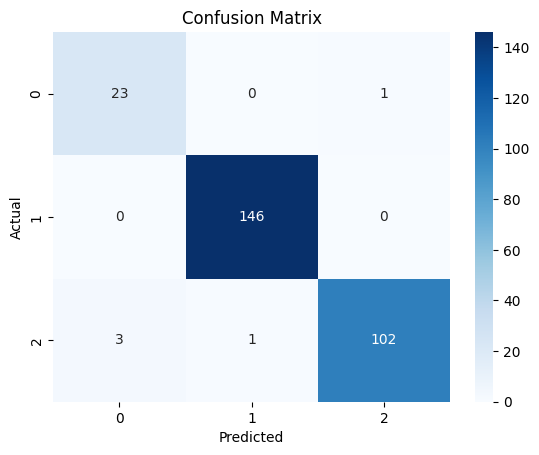

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


# Evaluate the model
print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred_bool)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Results**

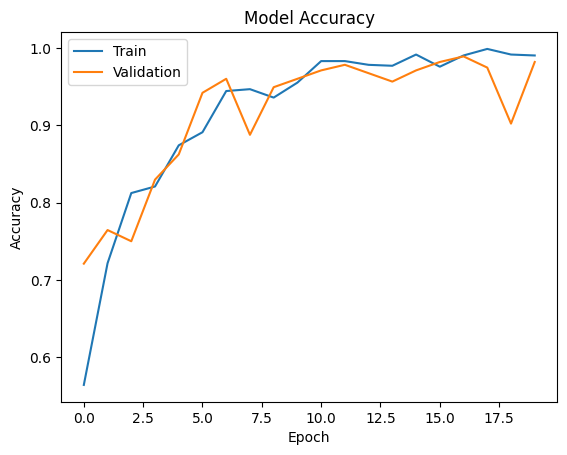

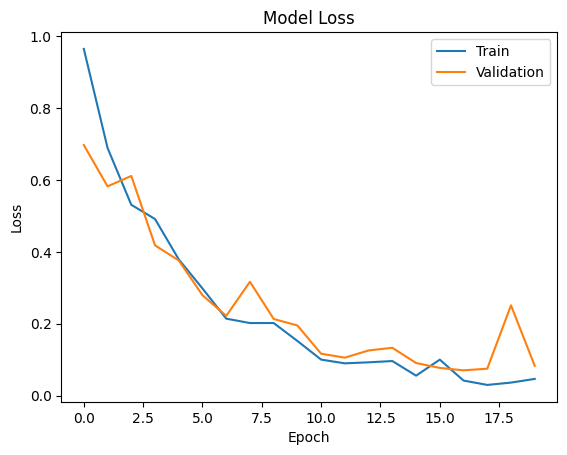

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Saving the model using Keras(option1) ##

In [ ]:


# Save the trained model to a file using pickle
# with open("/content/drive/MyDrive/Btech Related /Major project/Multiple Disease Detection/lung cancer/lung_cancer_model.pkl", "wb") as model_file:
#     pk.dump(model, model_file)
model.save('/content/drive/MyDrive/lung_cancer_model.h5')

In [ ]:
# with open("/content/drive/MyDrive/Btech Related /Major project/Multiple Disease Detection/lung cancer/lung_cancer_model.pkl", 'rb') as model_file:
#     loaded_model = pk.load(model_file)
loaded_model = load_model('lung_cancer_model.h5')

## Saving the model using pickle (option2) ##

In [ ]:
# Save the trained model to a file using pickle
with open("/content/drive/MyDrive/Btech Related /Major project/Multiple Disease Detection/lung cancer/lung_cancer_model.pkl", "wb") as model_file:
pk.dump(model, model_file)

## Testing model using Keras ##

## Testing the model using pickle##

In [ ]:
import pickle as pk
import cv2
import numpy as np

# Load the trained model using pickle
with open("/content/drive/MyDrive/Btech Related /Major project/Multiple Disease Detection/lung cancer/lung_cancer_model.pkl", 'rb') as model_file:
    loaded_model = pk.load(model_file)

# Load and preprocess the input image
image_path = "/content/Malignant case (1).jpg"
image = cv2.imread(image_path, 0)

# Check if the image is loaded successfully
if image is None:
    print("Error: Unable to load the image.")
else:
    image = cv2.resize(image, (256, 256))
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = image.reshape(1, 256, 256, 1)  # Add batch dimension and channels
    image = image / 255.0

    # Perform inference
    prediction = loaded_model.predict(image)

    # Interpret the model output
    # Assuming your model outputs a probability score
    threshold = 0.5  # You can adjust this threshold as needed
    if prediction[0][0] > threshold:
        print("Lung cancer detected")
    else:
        print("No lung cancer detected")


1/1 [==============================] - 0s 61ms/step
No lung cancer detected


In [ ]:
from google.colab import files
!files.download("/content/lung_cancer_model.h5")

/bin/bash: -c: line 1: syntax error near unexpected token `"/content/lung_cancer_model.h5"'
/bin/bash: -c: line 1: `files.download("/content/lung_cancer_model.h5")'
